Source: https://www.itl.nist.gov/div898/handbook/eda/section4/eda424.htm

## Preparation

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\An PC\\jupyter\\eda'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from utils import datasets
from utils import calculations
from utils.plotting import show_and_save_plot
from plots import four_plot, run_sequence_plot, histogram, lag_plot, probability_plot, \
                  autocorrelation_plot

---

# Josephson Junction Cryothermometry
This example illustrates the univariate analysis of Josephson junction cyrothermometry.
1. [Background and Data](#background)
2. [Graphical Output and Interpretation](#graphical)
3. [Quantitative Output and Interpretation](#quantitative)

---

## <a name="background"></a>Background and Data
### Generation 
This data set was collected by Bob Soulen of NIST in October, 1971 as a sequence of observations collected equi-spaced in time from a volt meter to ascertain the process temperature in a Josephson junction cryothermometry (low temperature) experiment. The response variable is voltage counts.

### Motivation
The motivation for studying this data set is to illustrate the case where there is discreteness in the measurements, but the underlying assumptions hold. In this case, the discreteness is due to the data being integers.

### Data source
https://www.itl.nist.gov/div898/handbook/datasets/SOULEN.DAT

In [3]:
df = datasets.load_josephson_junction_cryothermometry()
df.head()

,y
0,2899
1,2898
2,2898
3,2900
4,2898


---

## <a name="graphical"></a>Graphical Output and Interpretation
### Goal
The goal of this analysis is threefold:
1. Determine if the univariate model: $Y_i=C+E_i$ is appropriate and valid.
2. Determine if the typical underlying assumptions for an "in control" measurement process are valid. These assumptions are:
    * random drawings;
    * from a fixed distribution;
    * with the distribution having a fixed location; and
    * the distribution having a fixed scale. 
3. Determine if the confidence interval $\bar{Y}\pm\frac{2s}{\sqrt{N}}$ is appropriate and valid where $s$ is the standard deviation of the original data.

### 4-Plot of Data

In [4]:
def four_plot(series, main_title="4-PLOT", show=True, save=False,
              run_kws=None, lag_kws=None, hist_kws=None, prob_kws=None):

    fig, axes = plt.subplots(nrows=2, ncols=2,
                             gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0.3,
                                 },
                             figsize=(7, 8))
    rsp, lag = axes[0]
    hist, prob = axes[1]
    
    # Run Sequence Plot
    run_kws = run_kws if run_kws is not None else {}
    clearance = (max(series)-min(series)) * 1/10
    y_lim = (min(series)-clearance, max(series)+clearance)
    run_sequence_plot(series, y_lim=y_lim, ax=rsp, show=False, **run_kws)

    # Lag Plot
    lag_kws = lag_kws if lag_kws is not None else {}
    lag_plot(series, ax=lag, show=False, **lag_kws)
    
    # Histogram
    hist_kws = hist_kws if hist_kws is not None else {}
    histogram(series, ax=hist, show=False, **hist_kws)

    # Probability Plot
    prob_kws = prob_kws if prob_kws is not None else {}
    probability_plot(series, ax=prob, show=False, **prob_kws)
    
    fig.suptitle(main_title)
    
    show_and_save_plot(show=show, save=save, filename="4-plot.png")

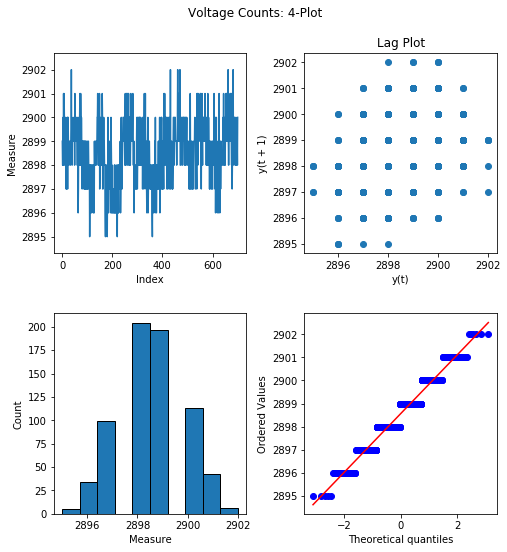

In [5]:
four_plot(df["y"], main_title="Voltage Counts: 4-Plot")

### Interpretation
The assumptions are addressed by the graphics shown above:
1. The run sequence plot (upper left) indicates that the data do not have any significant shifts in location or scale over time.
2. The lag plot (upper right) does not indicate any non-random pattern in the data.
3. The histogram (lower left) shows that the data are reasonably symmetric, there does not appear to be significant outliers in the tails, and that it is reasonable to assume that the data can be fit with a normal distribution.
4. The normal probability plot (lower right) is difficult to interpret due to the fact that there are only a few distinct values with many repeats. 

The integer data with only a few distinct values and many repeats accounts for the discrete appearance of several of the plots (e.g., the lag plot and the normal probability plot). In this case, the nature of the data makes the normal probability plot difficult to interpret, especially since each number is repeated many times. However, the histogram indicates that a normal distribution should provide an adequate model for the data.

From the above plots, we conclude that the underlying assumptions are valid and the data can be reasonably approximated with a normal distribution. Therefore, the commonly used uncertainty standard is valid and appropriate. The numerical values for this model are given in the [Quantitative Output and Interpretation](#quantitative) section.

### Individual Plots
Although it is normally not necessary, the plots can be generated individually to give more detail.

#### Run Sequence Plot

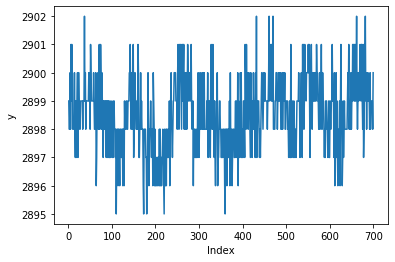

In [6]:
run_sequence_plot(df["y"], y_label="y")

#### Lag Plot

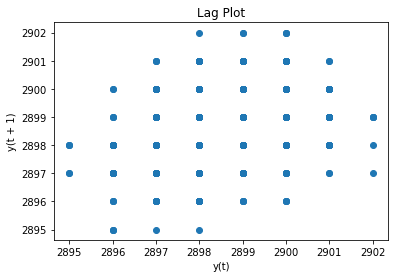

In [7]:
lag_plot(df["y"])

#### Histogram (with overlaid Normal PDF)

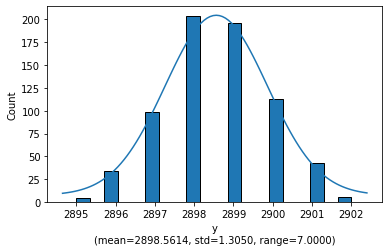

In [8]:
_, _, _ = histogram(df["y"], bins=20, x_label="y", plot_pdf=True, show_statistics=True)

#### Normal Probability Plot 

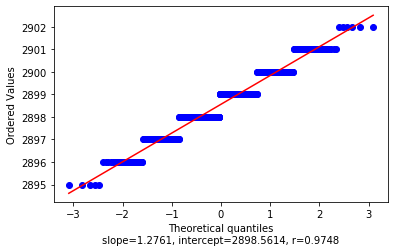

In [9]:
_, _ = probability_plot(df["y"], show_fitting=True)

---

## <a name="quantitative"></a>Quantitative Output and Interpretation

### Summary Statistics
As a first step in the analysis, common summary statistics are computed from the data.

In [10]:
df.describe()

,y
count,700.000000
mean,2898.561429
std,1.304969
min,2895.000000
25%,2898.000000
50%,2899.000000
75%,2899.000000
max,2902.000000


Because of the discrete nature of the data, we also compute the normal PPCC.

In [11]:
_, results = stats.probplot(df["y"], fit=True)
slope, intercept, r = results
print("Normal PPCC =", r)

Normal PPCC = 0.9748400935520328


### Location
One way to quantify a change in location over time is to fit a straight line to the data using an index variable as the independent variable in the regression. For our data, we assume that data are in sequential run order and that the data were collected at equally spaced time intervals. In our regression, we use the index variable $X = 1, 2, ..., N$, where $N$ is the number of observations. If there is no significant drift in the location over time, the slope parameter should be zero. 

In [12]:
Y = df["y"]
X = df.index.values + 1
X = sm.add_constant(X)

In [13]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     19.76
Date:                Mon, 30 Sep 2019   Prob (F-statistic):           1.02e-05
Time:                        19:58:04   Log-Likelihood:                -1169.3
No. Observations:                 700   AIC:                             2343.
Df Residuals:                     698   BIC:                             2352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2898.1861      0.097   2.97e+04      0.0

In [14]:
SSR = np.sqrt(results.mse_resid)
print("Residual Standard Deviation =", SSR)
print("Residual Degrees of Freedom =", results.df_resid)

Residual Standard Deviation = 1.2878024734193994
Residual Degrees of Freedom = 698.0


The absolute value of the *t*-value for the slope parameter is smaller than the critical value of $t_{0.975, 498} = 1.96$. Thus, we conclude that the slope is not different from zero at the 0.05 significance level.

### Variation
One simple way to detect a change in variation is with a __Bartlett test__ after dividing the data set into several equal-sized intervals. However, the Bartlett test is not robust for non-normality. Since the nature of the data (a few distinct points repeated many times) makes the normality assumption questionable, we use the alternative Levene test. In particular, we use the __Levene test__ based on the median rather the mean. The choice of the number of intervals is somewhat arbitrary, although values of four or eight are reasonable. We will divide our data into four intervals. 

In [15]:
Y = df["y"]
G1, G2, G3, G4 = Y[:175], Y[175:350], Y[350:525], Y[525:]
for G in (Y, G1, G2, G3, G4):
    print(len(G))

700
175
175
175
175


Null and alternative hypothesis

$H_0$:  $\sigma_1^2 = \sigma_2^2 = \sigma_3^2 = \sigma_4^2$

$H_a$:  At least one $\sigma_i^2$ is not equal to the others.

In [16]:
W, p_value = stats.levene(G1, G2, G3, G4)
print("Test statistic =", W)
print("p-value =", p_value)

Test statistic = 1.4323661190526964
p-value = 0.2320983109427649


In this case, Levene test indicates that the variances are not significantly different in the four intervals.

### Randomness
here are many ways in which data can be non-random. However, most common forms of non-randomness can be detected with a few simple tests. The lag plot in the previous section is a simple graphical technique.

Another check is an autocorrelation plot that shows the autocorrelations for various lags. Confidence bands can be plotted at the 95 % and 99 % confidence levels. Points outside this band indicate statistically significant values (lag 0 is always 1).

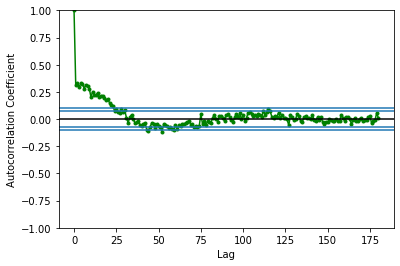

lag = 0, autocorrelation coefficient = 1.000
lag = 1, autocorrelation coefficient = 0.315
lag = 2, autocorrelation coefficient = 0.333
lag = 3, autocorrelation coefficient = 0.293
lag = 4, autocorrelation coefficient = 0.331


In [17]:
coefs, _, _ = autocorrelation_plot(df["y"], max_lag=180, c="green", marker=".")
for lag, coef in enumerate(coefs[:5]):
    print("lag = {}, autocorrelation coefficient = {:.3f}".format(lag, coef))

The lag 1 autocorrelation, which is generally the one of most interest, is 0.315. The critical values at the 5 % level of significance are -0.087 and 0.087. This indicates that the lag 1 autocorrelation is statistically significant, so there is some evidence for non-randomness.

A common test for randomness is the [Bardley runs test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35d.htm).

*Hypotheses*

>$H_0$:  the sequence was produced in a random manner
>
>$H_a$:  the sequence was not produced in a random manner

*Results*

> Test statistic: $Z = -13.4162$
>
> Significance level: $\alpha = 0.05$
>
> Critical value: $Z_{1-\frac{\alpha}{2}} = 1.96$
>
> Critical region:  Reject $H_0$ if $|{Z}| \gt 1.96$ 

The runs test indicates non-randomness.

Although the runs test and lag 1 autocorrelation indicate some mild non-randomness, it is not sufficient to reject the $Y_i = C + E_i$ model. At least part of the non-randomness can be explained by the discrete nature of the data.

### Distributional Analysis
Probability plots are a graphical test for assessing if a particular distribution provides an adequate fit to a data set.

A quantitative enhancement to the probability plot is the correlation coefficient of the points on the probability plot, or PPCC. For this data set the PPCC based on a normal distribution is 0.975. Since the PPCC is less than the critical value of 0.987 (this is a tabulated value), the normality assumption is rejected.

Chi-square and Kolmogorov-Smirnov goodness-of-fit tests are alternative methods for assessing distributional adequacy. The Wilk-Shapiro and Anderson-Darling tests can be used to test for normality. The results of the Anderson-Darling test follow. 

In [18]:
statistic, critical_values, significance_levels = stats.anderson(df["y"])
print("AD statistic =", statistic)
for level, crit in zip(significance_levels, critical_values):
    print("Critical value = {} at significance level = {}".format(crit, level))

AD statistic = 16.763401885719645
Critical value = 0.573 at significance level = 15.0
Critical value = 0.652 at significance level = 10.0
Critical value = 0.783 at significance level = 5.0
Critical value = 0.913 at significance level = 2.5
Critical value = 1.086 at significance level = 1.0


The Anderson-Darling test rejects the normality assumption at the 0.05 significance level.

### Outlier Analysis
A test for outliers is the [Grubbs test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm).

*Hypotheses*

>$H_0$: there are no outliers in the data
>
>$H_a$: the maximum value is an outlier

*Results*

>Test statistic:  $G = 2.729201$
>
>Significance level: $\alpha = 0.05$
>
>Critical value for an upper one-tailed test: $G_{crit}=3.863087$
>
>Critical region: Reject $H_0$ if $G\gt3.863087$

For this data set, Grubbs' test does not detect any outliers at the 0.05 significance level. 

In [19]:
!pip install outlier_utils
from outliers import smirnov_grubbs as grubbs

In [20]:
outliers = grubbs.max_test_outliers(df["y"], alpha=0.05)
if len(outliers) == 0:
    print("The maximum value is not an outlier.")
else:
    print("Outliers:", outliers)

The maximum value is not an outlier.


c:\users\an pc\jupyter\.venv\lib\site-packages\outliers\smirnov_grubbs.py:185: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return data.argmax()


### Model
Although the randomness and normality assumptions were mildly violated, we conclude that a reasonable model for the data is:$Y_i=2898.7+E_i$. In addition, a 95 % confidence interval for the mean value is (2898.515, 2898.928).

### Univariate Report
It is sometimes useful and convenient to summarize the above results in a report.

>__Analysis for Josephson Junction Cryothermometry Data__
>
>
>1. Sample Size                           = 700
>
>
>2. Location
>
>
>* Mean                                  = 2898.562
>* Standard Deviation of Mean            = 0.049323
>* 95% Confidence Interval for Mean      = (2898.465,2898.658)
>* Drift with respect to location?       = YES (Further analysis indicates that the drift, while statistically significant, is not practically significant)
>
>
>3. Variation
>
>
>* Standard Deviation                    = 1.30497
>* 95% Confidence Interval for SD        = (1.240007,1.377169)
>* Drift with respect to variation? (based on Levene's test on quarters of the data) = NO
>
>
>4. Distribution
>
>
>* Normal PPCC                           = 0.97484
>* Normal Anderson-Darling               = 16.7634
>* Data are Normal? (as tested by Normal PPCC)          = NO
>* Data are Normal? (as tested by Normal PPCC)          = NO
>
>
>5. Randomness
>
>
>* Autocorrelation                       = 0.314802
>* Data are Random? (as measured by autocorrelation)    = NO
>
>
>6. Statistical Control (i.e., no drift in location or scale, data are random, distribution is 
    fixed, here we are testing only for fixed normal)
>
>
>* Data Set is in Statistical Control?   = NO
>
>
>*Note:* Although we have violations of the assumptions, they are mild enough, and at least partially explained by the discrete nature of the data, so we may model the data as if it were in statistical control.
>
>
>7. Outliers? (as determined by Grubbs test)        = NO

---